In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb
print(xgb.__version__)

1.7.1


##Data Augmentation
- Dia das mães
- Nome da loja
- Feriado

##Algoritmos
- ANN
- XGBoost
- TSAI
- SARIMA



- entrega dia 17/11
- csv com as predicoes
- codigo
- relatorio
    - arquitetura da solução
    - medidas de avaliacao
    - achados e dificuldades
    - licoes aprendidas

In [2]:
def split_data(df):
  web = df[df['tipo_loja'] == 'web']
  fisica = df[df['tipo_loja'] == 'física']

  return fisica, web

def adjust_data(df):
  df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%dT%H:%M:%S.%fZ')
  df = df.pivot(index='ds', columns='loja', values='venda').fillna(0).rename_axis(None, axis=1)

  return df
'''
def scale_data(df):
  for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1, 1)).reshape(1, -1)[0]

  return df
'''
def series_to_supervised(data, n_in=1, n_out=1):
	df = pd.DataFrame(data)
	cols = list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	agg = pd.concat(cols, axis=1)
	agg.dropna(inplace=True)
	return agg.values


In [3]:
class TSData:
    def __init__(self, column, df):
        self.name = column
        self.store_type = 'loja'
        self.data = df[[column]]
        self.scaler = MinMaxScaler()
        self.data[column + '_scaled'] = self.__scale_data(self.name, self.data)
        self.features = self.__create_features()

    def __str__(self):
        return f'{self.name} - data:{self.data.shape} - features:{self.features.shape}'

    def __scale_data(self, column, df):
        data = self.scaler.fit_transform(df[column].values.reshape(-1, 1))
        return data.reshape(1, -1)[0]

    def __create_features(self):
        features = pd.DataFrame()
        
        features['lag_1'] = self.data[self.name].shift(1)
        features['lag_2'] = self.data[self.name].shift(2)
        features['MA_3'] = self.data[self.name].rolling(3).mean()
        features['MA_7'] = self.data[self.name].rolling(7).mean()
        features['MA_14'] = self.data[self.name].rolling(14).mean()
        features['MA_21'] = self.data[self.name].rolling(21).mean()

        features['STD_3'] = self.data[self.name].rolling(3).std()
        features['STD_7'] = self.data[self.name].rolling(7).std()
        features['STD_14'] = self.data[self.name].rolling(14).std()
        features['STD_21'] = self.data[self.name].rolling(21).std()

        #features = features.fillna(0)
        #for c in features.columns:
        #    features[c] = self.__scale_data(c, features)

        return features

In [4]:
test_file = '../TF/data/renner_sales_sample_test.csv'
train_file = '../TF/data/renner_sales_sample_train.csv'

test_df = pd.read_csv(test_file)
train_df = pd.read_csv(train_file)

test = adjust_data(test_df)
train = adjust_data(train_df)

In [ ]:
test_df[test_df['loja'] == 'renner_ar_ex_1']['tipo_loja'][0]

In [5]:
#dicionario com as series separadas por loja
train_series = {}
for c in train.columns:
    train_series[c] = TSData(c, train)
    train_series[c].store_type = train_df[train_df['loja'] == c]['tipo_loja'].unique()[0]

test_series = {}
for c in test.columns:
    test_series[c] = TSData(c, test)
    test_series[c].store_type = test_df[test_df['loja'] == c]['tipo_loja'].unique()[0]

C:\Users\10087940\AppData\Local\Temp\ipykernel_9816\3785520574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[column + '_scaled'] = self.__scale_data(self.name, self.data)
C:\Users\10087940\AppData\Local\Temp\ipykernel_9816\3785520574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[column + '_scaled'] = self.__scale_data(self.name, self.data)
C:\Users\10087940\AppData\Local\Temp\ipykernel_9816\3785520574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
#tenta prever a venda de uma loja específica criando estimativas para cada semana
#as estimativas devem ser classificadas conforme o range de vendas da loja
#pex:
#range 1: 0-10
#range 2: 10-20
#range 3: 20-30
#e assim por diante
#desse modo o classificador pode ser treinado para prever o range de vendas da loja
#utilizar indicadores de tendência e sazonalidade para estimar o range de vendas
#utilizar o modelo de regressão linear para estimar o range de vendas
#utilizar o modelo de regressão logística para estimar o range de vendas
#utilizar indicadores financeiros para estimar o range de vendas, como por exemplo, 
# média móvel, média ponderada, média exponencial, bandas de bollinger e etc



# Avaliação do Modelo

In [6]:
#itera entre as series de features de cada loja, calculando o RMSE
model = XGBRegressor(learning_rate=.1)
scores_df = pd.DataFrame()
for tsc in train_series.values():
    print(tsc)

    X = tsc.features
    y = tsc.data[tsc.name]

    tscv = TimeSeriesSplit(n_splits=10, gap=1)

    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    
    #cria um dataframe com os scores de cada loja
    temp = pd.DataFrame(
            index=[tsc.name], 
            columns=(','.join(['sc_'+str(n) for n in range(len(scores))])).split(','), 
            data=[-scores])
    temp['RMSE'] = np.sqrt(-scores).mean()

    scores_df = pd.concat([scores_df, temp])

renner_ar_ex_1 - data:(275, 2) - features:(275, 10)
renner_ar_ex_2 - data:(275, 2) - features:(275, 10)
renner_ar_ex_3 - data:(275, 2) - features:(275, 10)
renner_ar_ex_4 - data:(275, 2) - features:(275, 10)
renner_br_ac_1 - data:(275, 2) - features:(275, 10)
renner_br_al_21 - data:(275, 2) - features:(275, 10)
renner_br_al_25 - data:(275, 2) - features:(275, 10)
renner_br_al_34 - data:(275, 2) - features:(275, 10)
renner_br_al_60 - data:(275, 2) - features:(275, 10)
renner_br_am_1 - data:(275, 2) - features:(275, 10)
renner_br_am_14 - data:(275, 2) - features:(275, 10)
renner_br_am_16 - data:(275, 2) - features:(275, 10)
renner_br_am_23 - data:(275, 2) - features:(275, 10)
renner_br_am_33 - data:(275, 2) - features:(275, 10)
renner_br_am_8 - data:(275, 2) - features:(275, 10)
renner_br_ap_16 - data:(275, 2) - features:(275, 10)
renner_br_ap_54 - data:(275, 2) - features:(275, 10)
renner_br_ba_1 - data:(275, 2) - features:(275, 10)
renner_br_ba_12 - data:(275, 2) - features:(275, 10)
r

In [7]:
scores_df

,sc_0,sc_1,sc_2,sc_3,sc_4,sc_5,sc_6,sc_7,sc_8,sc_9,RMSE
renner_ar_ex_1,4.281795e-10,2.749461e-10,2.371517e-10,2.202409e-10,2.106761e-10,15106.397993,2350.297518,583.953119,15.815707,1082.170197,23.242641
renner_ar_ex_2,4.281795e-10,2.749461e-10,2.371517e-10,2.202409e-10,2.106761e-10,23782.917255,68.844645,211.356813,29.260284,3155.360102,23.863445
renner_ar_ex_3,4.281795e-10,2.749461e-10,2.371517e-10,2.202409e-10,2.106761e-10,11081.038172,128.263551,158.623391,40.585855,1242.479165,17.080604
renner_ar_ex_4,4.281795e-10,2.749461e-10,2.371517e-10,2.202409e-10,2.106761e-10,15826.918189,709.616452,370.431211,48.230376,2312.442770,22.672305
renner_br_ac_1,1.407465e+03,4.039773e+03,1.468858e+03,2.141004e+03,8.632523e+02,3908.034730,3351.278596,5868.756086,898.316477,631.214510,46.716146
...,...,...,...,...,...,...,...,...,...,...,...
renner_uy_ex_5,4.281795e-10,2.159981e+00,1.417230e+03,5.771884e+03,2.330221e+03,2538.017815,38.269637,8326.447422,17.509821,39221.725072,51.340469
renner_uy_ex_6,4.281795e-10,2.749461e-10,1.526600e+03,1.063037e+04,4.850534e+02,871.209295,88.292002,4422.822084,13.418041,17306.976400,40.483537
renner_uy_ex_7,4.281795e-10,2.749461e-10,2.371517e-10,1.738092e+04,5.308396e+02,590.665273,14.753925,1395.847985,7.943459,13185.586588,33.802938
renner_uy_ex_8,4.281795e-10,2.749461e-10,2.371517e-10,2.202409e-10,2.106761e-10,28143.237274,287.681646,19002.672454,130.685582,47444.513063,55.182030


<AxesSubplot:ylabel='RMSE'>

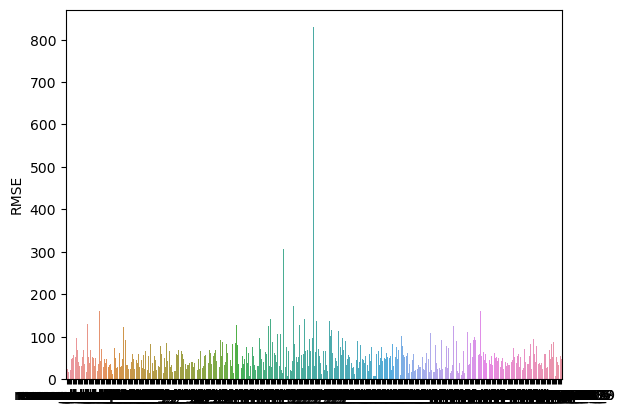

In [8]:
sns.barplot(data=scores_df, x=scores_df.index, y=scores_df['RMSE'])

In [9]:
scores_df[['RMSE']].describe()

,RMSE
count,406.000000
mean,51.991590
std,49.244895
min,6.986628
25%,29.743770
50%,45.614682
75%,61.599738
max,829.401889


# Treinamento do modelo

In [17]:
#realiza o treinamento do modelo
model = XGBRegressor(learning_rate=.1)
for tsc in train_series.values():
    #tsc = train_series['renner_br_ac_1']
    print(tsc)

    X = np.vstack(tsc.features.values)
    y = tsc.data[tsc.name]

    model.fit(X, y)

renner_ar_ex_1 - data:(275, 2) - features:(275, 10)
renner_ar_ex_2 - data:(275, 2) - features:(275, 10)
renner_ar_ex_3 - data:(275, 2) - features:(275, 10)
renner_ar_ex_4 - data:(275, 2) - features:(275, 10)
renner_br_ac_1 - data:(275, 2) - features:(275, 10)
renner_br_al_21 - data:(275, 2) - features:(275, 10)
renner_br_al_25 - data:(275, 2) - features:(275, 10)
renner_br_al_34 - data:(275, 2) - features:(275, 10)
renner_br_al_60 - data:(275, 2) - features:(275, 10)
renner_br_am_1 - data:(275, 2) - features:(275, 10)
renner_br_am_14 - data:(275, 2) - features:(275, 10)
renner_br_am_16 - data:(275, 2) - features:(275, 10)
renner_br_am_23 - data:(275, 2) - features:(275, 10)
renner_br_am_33 - data:(275, 2) - features:(275, 10)
renner_br_am_8 - data:(275, 2) - features:(275, 10)
renner_br_ap_16 - data:(275, 2) - features:(275, 10)
renner_br_ap_54 - data:(275, 2) - features:(275, 10)
renner_br_ba_1 - data:(275, 2) - features:(275, 10)
renner_br_ba_12 - data:(275, 2) - features:(275, 10)
r

In [16]:
#gera as predicoes para o conjunto de teste e salva em csv
predictions = pd.DataFrame(columns=['item', 'loja', 'tipo_loja', 'ds', 'venda'])
for tsc in test_series.values():
    print(tsc)
    #tsc = test_series['renner_br_ac_1']
    X_test = np.vstack(tsc.features.values)
    y_test = tsc.data[tsc.name]

    y_pred = model.predict(X_test)

    temp = pd.DataFrame()

    temp['ds'] = tsc.data.index
    temp['venda'] = tsc.scaler.inverse_transform(y_pred.reshape(-1, 1))
    temp['item'] = 10223
    temp['loja'] = tsc.name
    temp['tipo_loja'] = tsc.store_type

    predictions = pd.concat([predictions, temp])

    #salva o csv com as predicoes
    predictions.to_csv('predictions/predictions.csv', index=False)


renner_ar_ex_1 - data:(8, 2) - features:(8, 10)
renner_ar_ex_2 - data:(8, 2) - features:(8, 10)
renner_ar_ex_3 - data:(8, 2) - features:(8, 10)
renner_ar_ex_4 - data:(8, 2) - features:(8, 10)
renner_br_ac_1 - data:(8, 2) - features:(8, 10)
renner_br_al_21 - data:(8, 2) - features:(8, 10)
renner_br_al_25 - data:(8, 2) - features:(8, 10)
renner_br_al_34 - data:(8, 2) - features:(8, 10)
renner_br_al_60 - data:(8, 2) - features:(8, 10)
renner_br_am_1 - data:(8, 2) - features:(8, 10)
renner_br_am_14 - data:(8, 2) - features:(8, 10)
renner_br_am_16 - data:(8, 2) - features:(8, 10)
renner_br_am_23 - data:(8, 2) - features:(8, 10)
renner_br_am_33 - data:(8, 2) - features:(8, 10)
renner_br_am_8 - data:(8, 2) - features:(8, 10)
renner_br_ap_16 - data:(8, 2) - features:(8, 10)
renner_br_ap_54 - data:(8, 2) - features:(8, 10)
renner_br_ba_1 - data:(8, 2) - features:(8, 10)
renner_br_ba_12 - data:(8, 2) - features:(8, 10)
renner_br_ba_13 - data:(8, 2) - features:(8, 10)
renner_br_ba_14 - data:(8, 2

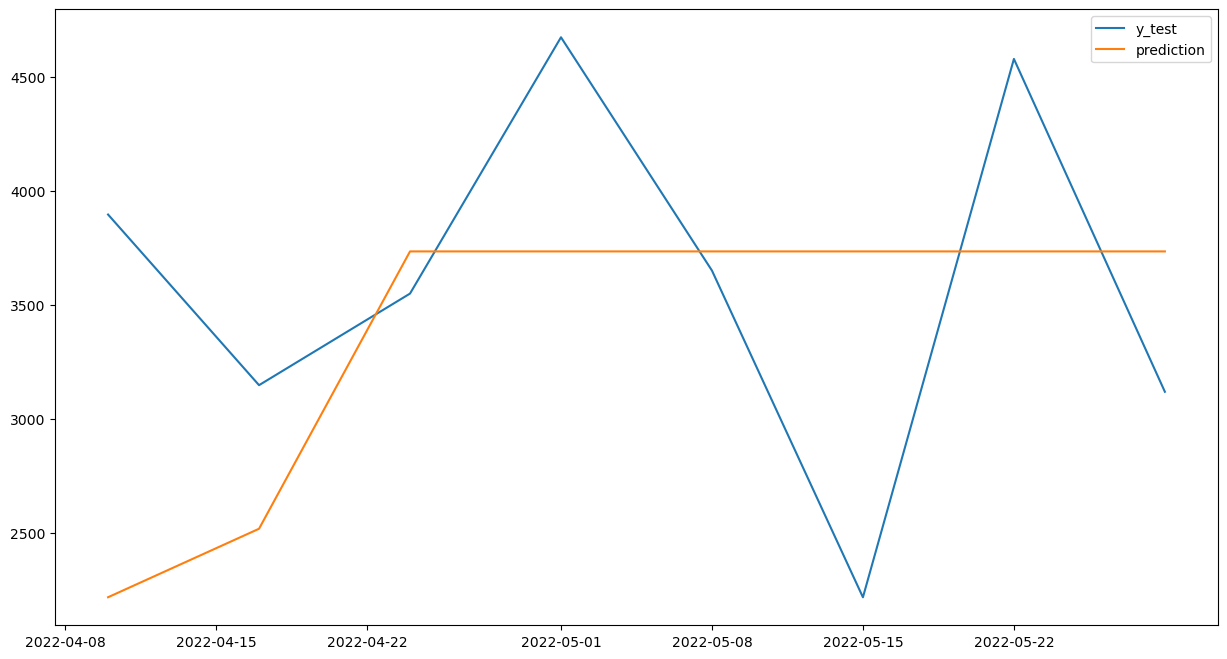

In [27]:
#renner_br_sp_2
#renner_br_rs_6
#renner_br_rj_81
tsc = test_series['renner_br_rj_81']
pred = predictions[predictions['loja'] == tsc.name].set_index('ds')

fig = plt.figure(figsize=(15,8))
plt.plot(tsc.data[tsc.name], label='y_test')
plt.plot(pred['venda'], label='prediction')
plt.legend()
plt.show()